# Computational example 1: Comparing AM sampling for the toy problem  

In [223]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

4


In [224]:
# Import module. 
using Revise
using PriorNormalization

In [225]:
# Import packages 
using AdaptiveMCMC # for using adaptive MCMC sampling
using AdvancedMH # for using MH sampling 
using ApproxFun # for approximating gammainvccdf by a Chebychev interpolant to then use AD  
using CairoMakie # for plots
using Dates # to measure computational time 
using FlexiMaps # for log-range
using ForwardDiff # for AD
using KernelDensity # for estimating densities from samples 
using LinearAlgebra 
using Printf # for specific output format
using QuadGK # for numerical integration 
using Random # for setting the random seed 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SpecialFunctions
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Sampling parameters and toy problem 

We use an adaptive RWMH sampler. See https://mvihola.github.io/docs/AdaptiveMCMC.jl/ or https://github.com/mvihola/AdaptiveMCMC.jl for details. 

In [226]:
# Prepare arguments.  
nr_chains = 4 # number of chains to sample 
nr_samples = 10^6 # number of samples 
nr_parameters = 2

# Select the model i=1,2,3,4 for r=1,1/2,-1/2,-1
model_nr = 2

# Set the random seed
Random.seed!(123)

# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Fix model parameters.
y = .2 # observational data 
σ² = 10^(-2.8) # noise variance

0.001584893192461114

## Prepare the models

In [227]:
# Define the posterior density 
function logpdf_original(θ, x; y, σ², r, β, ϑ)
    if θ <= 0 
        logpdf = -Inf 
    else
        logpdf = -(0.5/σ²)*(x-y)^2 - 0.5*x^2/θ - (θ/ϑ)^r + (r*β-1.5)*log.(θ)
    end
    
    return logpdf
end

# Define the posterior density 
function logpdf_priorNormalized(τ, u; y, σ², r, β, ϑ, Φ::Function) 
    x = priorNormalizing_KR_inv_tu_fast( u, τ; r, β, ϑ, Φ ) 
    logpdf = -(.5/σ²)*(x-y)^2 - 0.5*( u^2 + τ^2 )
    
    return logpdf
end

logpdf_priorNormalized (generic function with 2 methods)

## Select the model

In [228]:
# Select hyper-prior parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.0059323

In [229]:
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Calculate the value and derivative at the boundaries
Γinvccdf_val_left = Γinvccdf_cheb(interval.left)
Γinvccdf_val_right = Γinvccdf_cheb(interval.right)

Γinvccdf_deriv_left = ForwardDiff.derivative(Γinvccdf_cheb, interval.left)
Γinvccdf_deriv_right = ForwardDiff.derivative(Γinvccdf_cheb, interval.right)

# Define the extended function
function Γinvccdf_cheb_extd(τ)
    if τ < interval.left
        return Γinvccdf_val_left + Γinvccdf_deriv_left * (τ - interval.left)
    elseif τ > interval.right
        return abs(Γinvccdf_val_right + Γinvccdf_deriv_right * (τ - interval.right))
    else
        return Γinvccdf_cheb(τ)
    end
end

Γinvccdf_cheb_extd (generic function with 1 method)

In [230]:
# Change definition and define negative log-PDF
logpdf_original(z) = logpdf_original(
    z[1], z[2]; y, σ², r, β, ϑ
)

# Change definition and define negative log-PDF
logpdf_priorNormalized(z) = logpdf_priorNormalized(
    z[1], z[2]; y, σ², r, β, ϑ, Φ=Γinvccdf_cheb_extd
)

logpdf_priorNormalized (generic function with 2 methods)

### MAP estimation 

In [231]:
# Initial guess for the optimization (θ and x)
initial_guess = [1e-3; 0.0]
neg_logpdf_original(z) = -logpdf_original(z)

# MAP estimation  
@show MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 10_000, time_limit = 60.0)
)

# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1]
x_MAP = MAP_values[2] 

MAP_original = optimize(neg_logpdf_original, initial_guess, LBFGS(), Optim.Options(iterations = 10000, time_limit = 60.0)) =  * Status: success

 * Candidate solution
    Final objective value:     2.942188e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.96e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.11e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.06e-15 ≰ 0.0e+00
    |g(x)|                 = 7.33e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 60)
    Iterations:    14
    f(x) calls:    62
    ∇f(x) calls:   62



0.1851586355673303

In [232]:
# Initial guess for the optimization (θ and x)
initial_guess = [0.0; 0.0]
neg_logpdf_priorNormalized(z) = -logpdf_priorNormalized(z)

# MAP estimation  
@show MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 10_000, time_limit = 60.0)
)

# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1]
u_MAP = MAP_values[2]

MAP_priorNormalized = optimize(neg_logpdf_priorNormalized, initial_guess, LBFGS(), Optim.Options(iterations = 10000, time_limit = 60.0)) =  * Status: success

 * Candidate solution
    Final objective value:     3.486558e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.57e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.13e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.07e-12 ≰ 0.0e+00
    |g(x)|                 = 2.20e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 60)
    Iterations:    7
    f(x) calls:    21
    ∇f(x) calls:   21



0.7606788573417826

## Sampling

In [233]:
# Produce samples. 
init_param = [θ_MAP, x_MAP]
chn_values = zeros(Float64, nr_samples, nr_parameters, nr_chains)

# Start the wall clock timer
wall_start = now()

# Use multiple threads. 
Threads.@threads for j in 1:nr_chains 
    # Start the compute timer for each chain
    compute_start = time()
    
    # generate samples
    chn_values[:,:,j] = adaptive_rwm(
        init_param, 
        logpdf_original, 
        nr_samples; # number of samples (add burn-in length) 
        algorithm=:asm, 
        b=1, # no burn-in
        thin=1, # no thinning
        progress=true # show progress meter
    ).X'

    # Clear memory after each chain
    GC.gc()
end

# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
# Convert wall duration to seconds
wall_duration_original = Dates.value(wall_duration_ms) / 1000

# Define the parameter names (optional)
param_names = ["θ", "x"]

# Create the Chains object
chn_original = Chains(chn_values, Symbol.(param_names))

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

Progress: 100%|█████████████████████████████████████████| Time: 0:00:014:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [234]:
# Compute the mean acceptance rate

# Initialize an array to store acceptance rates for each chain
nr_chains = size(chn_original.value, 3)
acceptance_rates = zeros(nr_chains) 

# Compute the acceptance rate for each chain
Threads.@threads for j in 1:nr_chains
    accepted = 0
    for i in 2:size(chn_original.value, 1)
        # Compare z parameters between successive iterations
        if any(chn_original.value[i, :, j] .!= chn_original.value[i-1, :, j])
            accepted += 1
        end
    end
    acceptance_rate = accepted / (nr_samples - 1)
    acceptance_rates[j] = acceptance_rate
end

# Compute the average acceptance rate
average_acceptance_rate = mean(acceptance_rates)

# Print acceptance rates for each chain
for (j, rate) in enumerate(acceptance_rates)
    println("Chain $j acceptance rate: $rate")
end
println("Average acceptance rate: $average_acceptance_rate")

Chain 1 acceptance rate: 0.23387423387423387
Chain 2 acceptance rate: 0.23391223391223392
Chain 3 acceptance rate: 0.2336142336142336
Chain 4 acceptance rate: 0.2336932336932337
Average acceptance rate: 0.23377348377348378


In [235]:
# Produce samples. 
init_param = [τ_MAP, u_MAP]
chn_values = zeros(Float64, nr_samples, nr_parameters, nr_chains)

# Start the wall clock timer
wall_start = now()

# Use multiple threads. 
Threads.@threads for j in 1:nr_chains 
    # Start the compute timer for each chain
    compute_start = time()
    
    # generate samples
    chn_values[:,:,j] = adaptive_rwm(
        init_param, 
        logpdf_priorNormalized, 
        nr_samples; # number of samples (add burn-in length) 
        algorithm=:asm, 
        b=1, # no burn-in
        thin=1, # no thinning
        progress=true # show progress meter
    ).X'

    # Clear memory after each chain
    GC.gc()
end

# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
# Convert wall duration to seconds
wall_duration_priorNormalized = Dates.value(wall_duration_ms) / 1000

# Define the parameter names (optional)
param_names = ["τ", "u"]

# Create the Chains object
chn_priorNormalized = Chains(chn_values, Symbol.(param_names))

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

Progress: 100%|█████████████████████████████████████████| Time: 0:00:020:58
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [236]:
# Compute the mean acceptance rate

# Initialize an array to store acceptance rates for each chain
nr_chains = size(chn_priorNormalized.value, 3)
acceptance_rates = zeros(nr_chains) 

# Compute the acceptance rate for each chain
Threads.@threads for j in 1:nr_chains
    accepted = 0
    for i in 2:size(chn_priorNormalized.value, 1)
        # Compare z parameters between successive iterations
        if any(chn_priorNormalized.value[i, :, j] .!= chn_priorNormalized.value[i-1, :, j])
            accepted += 1
        end
    end
    acceptance_rate = accepted / (nr_samples - 1)
    acceptance_rates[j] = acceptance_rate
end

# Compute the average acceptance rate
average_acceptance_rate = mean(acceptance_rates)

# Print acceptance rates for each chain
for (j, rate) in enumerate(acceptance_rates)
    println("Chain $j acceptance rate: $rate")
end
println("Average acceptance rate: $average_acceptance_rate")

Chain 1 acceptance rate: 0.23445623445623445
Chain 2 acceptance rate: 0.23446823446823448
Chain 3 acceptance rate: 0.23392923392923393
Chain 4 acceptance rate: 0.23421623421623422
Average acceptance rate: 0.23426748426748428


In [237]:
# Tranform the chain for (τ,u) into a chain for (x,θ) 

# Array to store the sample values
nr_samples = size(chn_priorNormalized.value, 1)
chn_values = similar(chn_priorNormalized.value)  

# Change the parameter values 
# Transform each (τ,u) into (θ,x) samples 
Threads.@threads for j in 1:nr_chains
    for i in 1:nr_samples    
        τ = chn_priorNormalized.value[i, 1, j]
        u = chn_priorNormalized.value[i, 2, j]
        x, θ = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdf_cheb_extd )
        chn_values[i, 1, j] = θ
        chn_values[i, 2, j] = x
    end
end

# Change the parameter names 
# Extract the names of the parameters
parameter_names = names(chn_priorNormalized)
# Convert parameter names from symbols to strings
parameter_names_str = string.(parameter_names)
# Rename τ/u parameters to θ/x
signal_names_str = replace.(parameter_names_str, "τ" => "θ", "u" => "x")
# Convert parameter names back to symbols
signal_names = Symbol.(signal_names_str)

# Convert the transformed array back to a Chains object with updated parameter names
chn_pullback = Chains(chn_values, signal_names); 

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

## Trace plots

In [238]:
# Extract samples from the original and prior-normalized posterior 

# Extract samples from the original posterior 
x_original_samples = get(chn_original[1:100:end, :, :], :x).x;
θ_original_samples = get(chn_original[1:100:end, :, :], :θ).θ;

# Extract samples from the prior-normalized posterior 
u_samples = get(chn_priorNormalized[1:100:end, :, :], :u).u;
τ_samples = get(chn_priorNormalized[1:100:end, :, :], :τ).τ;

# Extract pullback samples  
x_priorNormalized_samples = get(chn_pullback[1:100:end, :, :], :x).x;
θ_priorNormalized_samples = get(chn_pullback[1:100:end, :, :], :θ).θ;

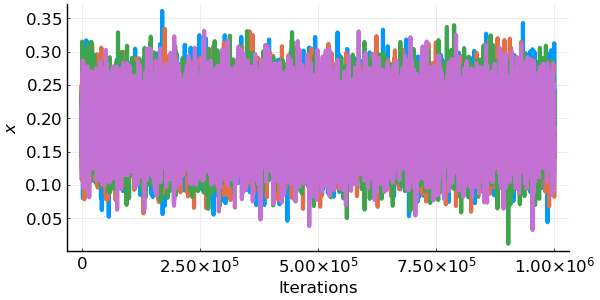

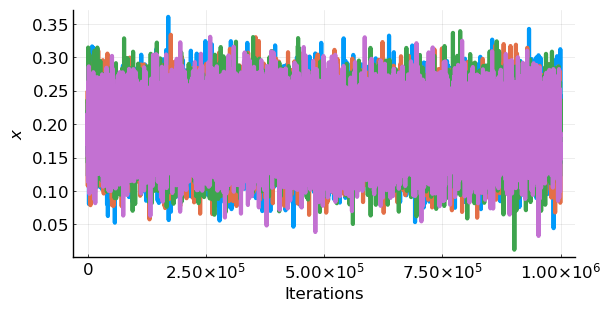

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_x_original.pdf"

In [239]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, x_original_samples, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_x_original.pdf")
#savefig(output_filename)

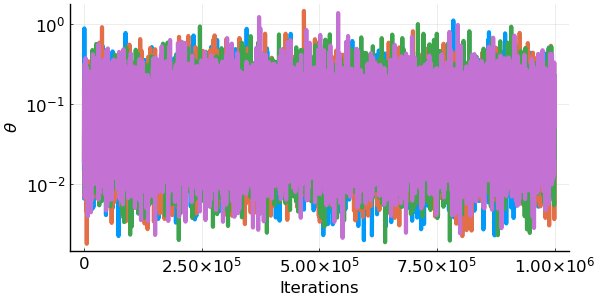

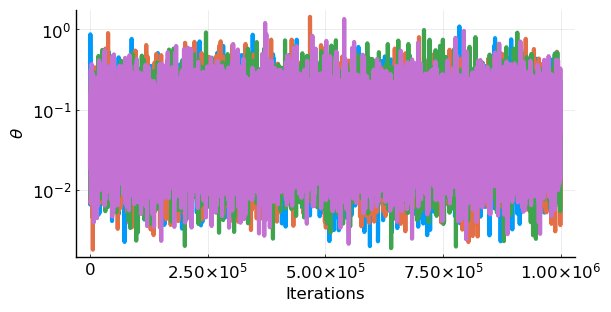

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_theta_original.pdf"

In [240]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, θ_original_samples, 
    lw=3, 
    yscale=:log10,
    legend=false, 
    xlabel="Iterations", ylabel=L"\theta",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_theta_original.pdf")
#savefig(output_filename)

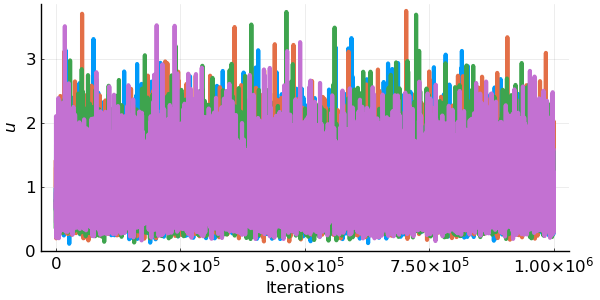

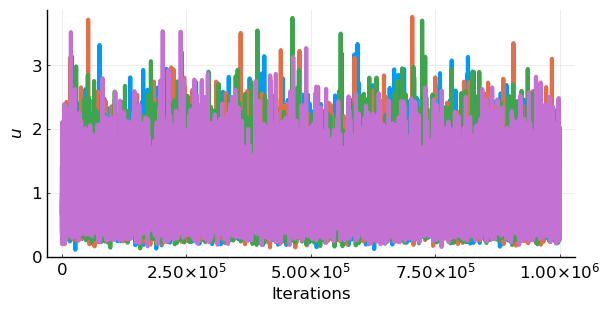

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_u.pdf"

In [241]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, u_samples, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"u",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_u.pdf")
#savefig(output_filename)

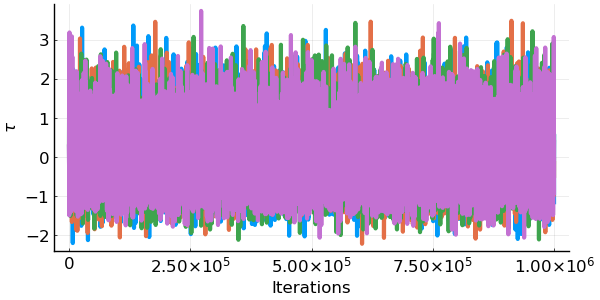

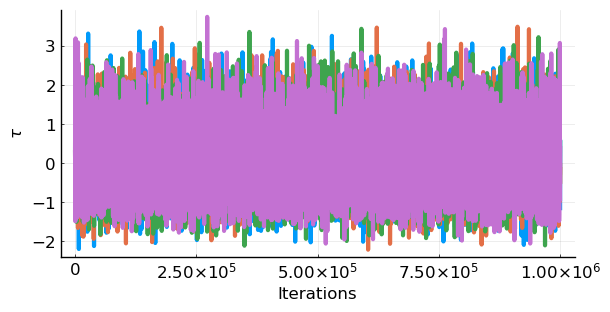

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_tau.pdf"

In [242]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, τ_samples, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"\tau",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_tau.pdf")
#savefig(output_filename)

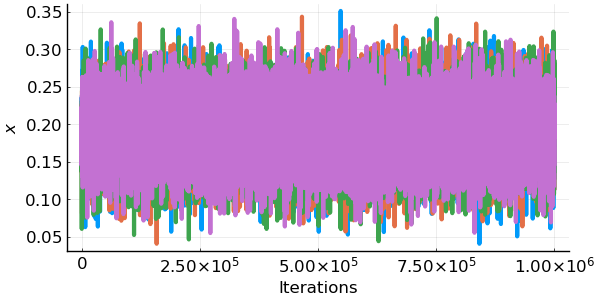

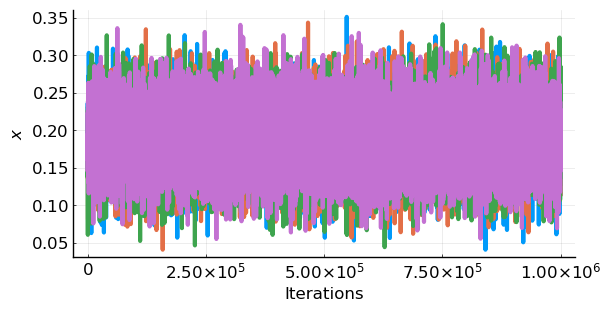

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_x_priorNormalized.pdf"

In [243]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, x_priorNormalized_samples, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_x_priorNormalized.pdf")
#savefig(output_filename)

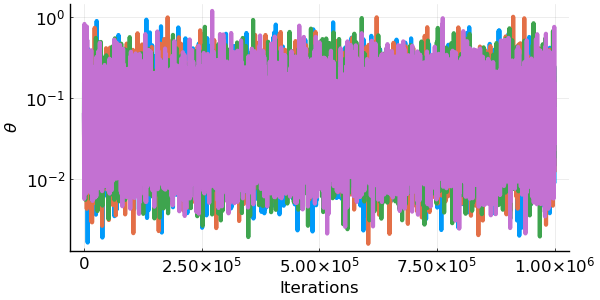

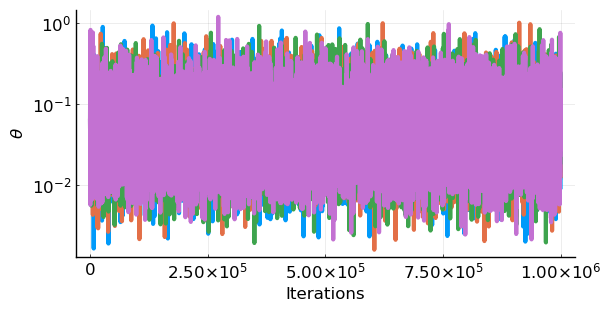

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_theta_priorNormalized.pdf"

In [244]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:100:nr_samples, θ_priorNormalized_samples, 
    lw=3, 
    yscale=:log10,
    legend=false, 
    xlabel="Iterations", ylabel=L"\theta",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_theta_priorNormalized.pdf")
#savefig(output_filename)

## Zoom into last part of trace

In [245]:
# Select sub-chains 
I_all = size(chn_original, 1)
I_sub = I_all - 1000
chn_original_sub = chn_original[I_sub:I_all, :, :];
chn_priorNormalized_sub = chn_priorNormalized[I_sub:I_all, :, :];
chn_pullback_sub = chn_pullback[I_sub:I_all, :, :];

# Extract samples from the original posterior 
x_original_samples_sub = get(chn_original_sub, :x).x;
θ_original_samples_sub = get(chn_original_sub, :θ).θ;

# Extract samples from the prior-normalized posterior 
u_samples_sub = get(chn_priorNormalized_sub, :u).u;
τ_samples_sub = get(chn_priorNormalized_sub, :τ).τ;

# Extract samples from the pullback posterior 
x_priorNormalized_samples_sub = get(chn_pullback_sub, :x).x;
θ_priorNormalized_samples_sub = get(chn_pullback_sub, :θ).θ;

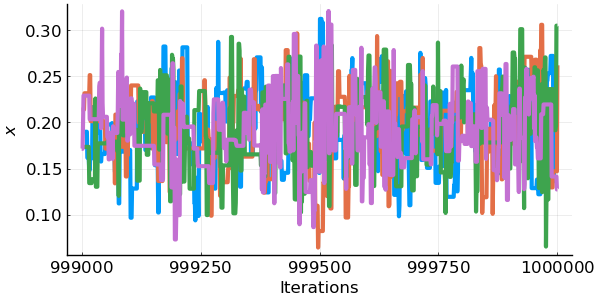

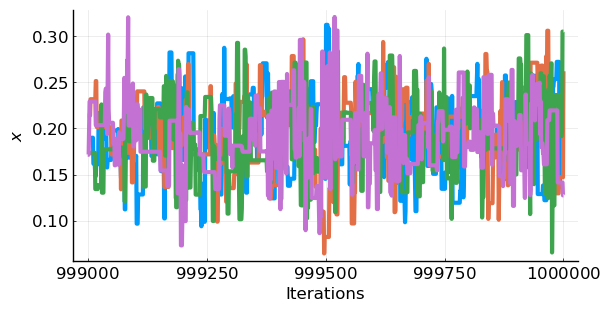

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_x_original_zoom.pdf"

In [246]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, x_original_samples_sub, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_x_original_zoom.pdf")
#savefig(output_filename)

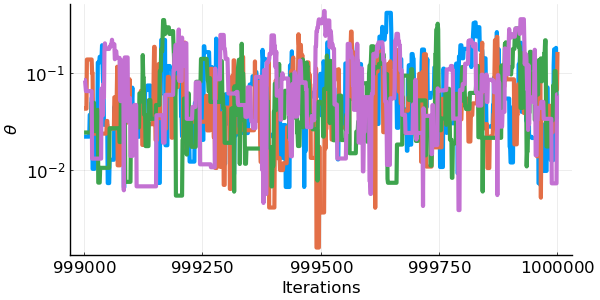

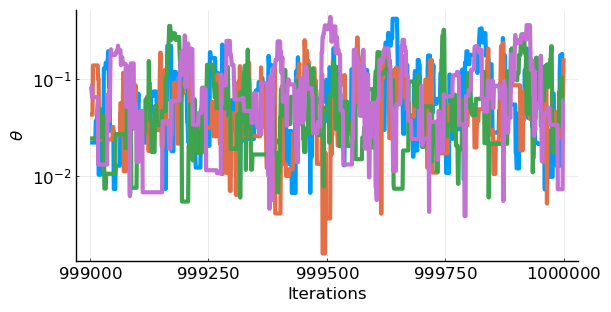

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_theta_original_zoom.pdf"

In [247]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, θ_original_samples_sub, 
    yscale=:log10,
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"\theta",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_theta_original_zoom.pdf")
#savefig(output_filename)

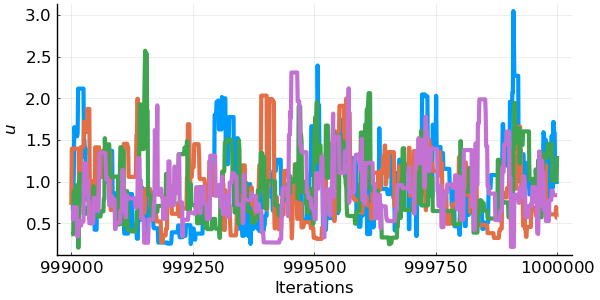

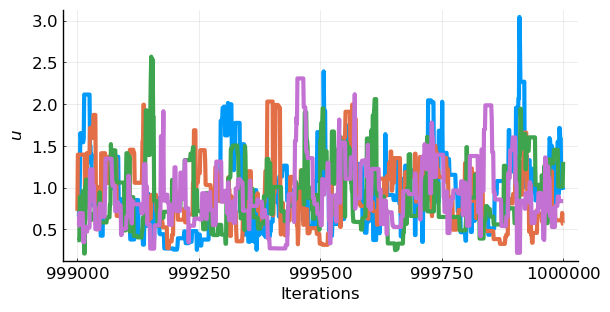

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_u_zoom.pdf"

In [248]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, u_samples_sub, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"u",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_u_zoom.pdf")
#savefig(output_filename)

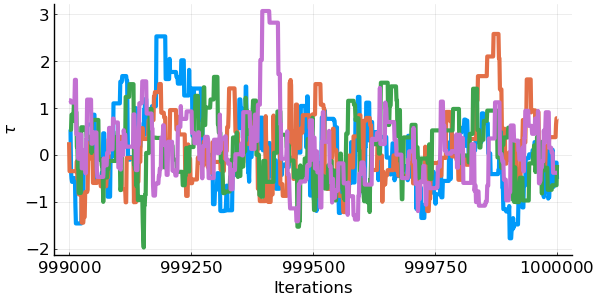

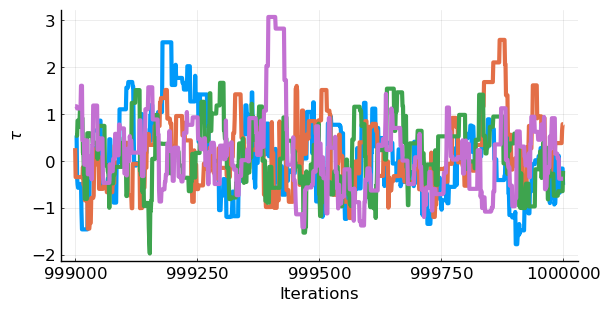

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_tau_zoom.pdf"

In [249]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, τ_samples_sub, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"\tau",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_tau_zoom.pdf")
#savefig(output_filename)

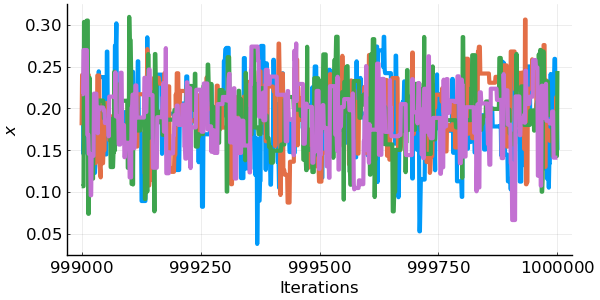

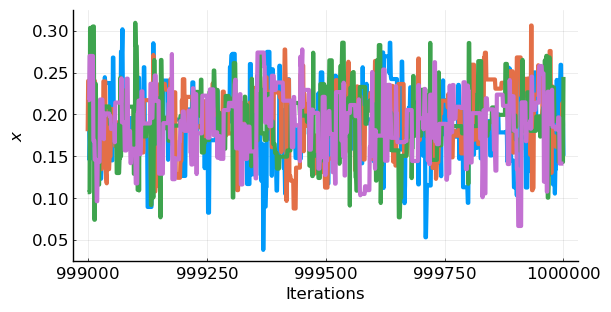

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_x_priorNormalized_zoom.pdf"

In [250]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, x_priorNormalized_samples_sub, 
    ylim=[.025,.325],
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_x_priorNormalized_zoom.pdf")
#savefig(output_filename)

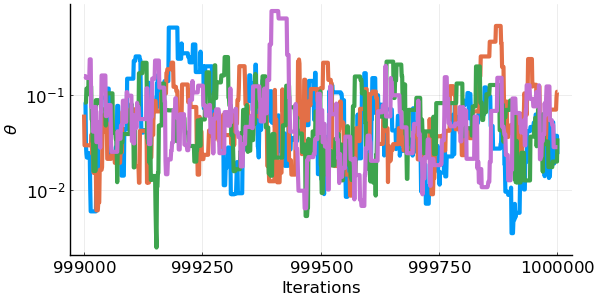

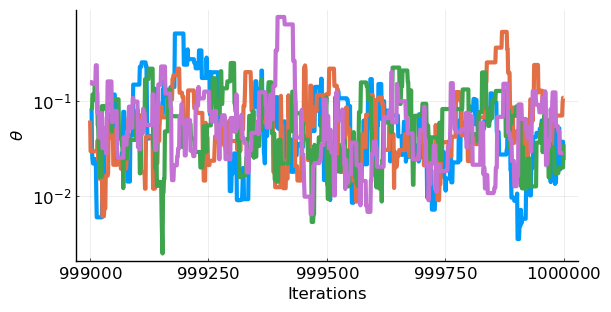

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_traces_theta_priorNormalized_zoom.pdf"

In [251]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    I_sub:I_all, θ_priorNormalized_samples_sub, 
    yscale=:log10,
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"\theta",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_traces_theta_priorNormalized_zoom.pdf")
#savefig(output_filename)

### Autocorrelation

┌ Warning: Invalid negative or zero value -0.0005316328148803787 found at series index 46 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.00014811419047545065 found at series index 48 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.0006442375920195574 found at series index 50 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.00025741823348456993 found at series index 26 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -2.7190127912008126e-5 found at series index 43 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -6.334642549883559e-5 found at series index 44 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kL

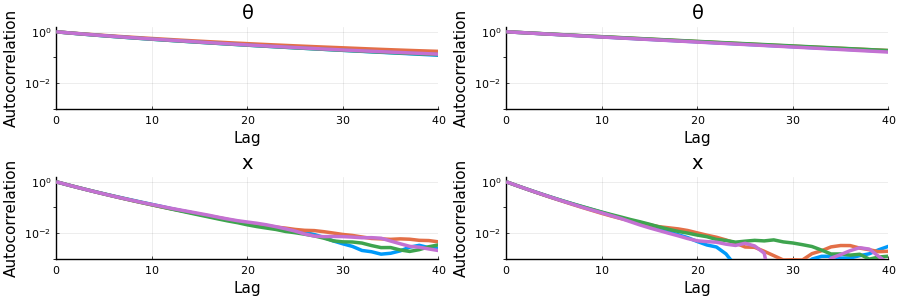

┌ Warning: Invalid negative or zero value -0.00014811419047545065 found at series index 48 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.0006442375920195574 found at series index 50 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.00025741823348456993 found at series index 26 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -2.7190127912008126e-5 found at series index 43 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -6.334642549883559e-5 found at series index 44 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/kLeqV/src/utils.jl:106
┌ Warning: Invalid negative or zero value -0.00016890684191749319 found at series index 30 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/k

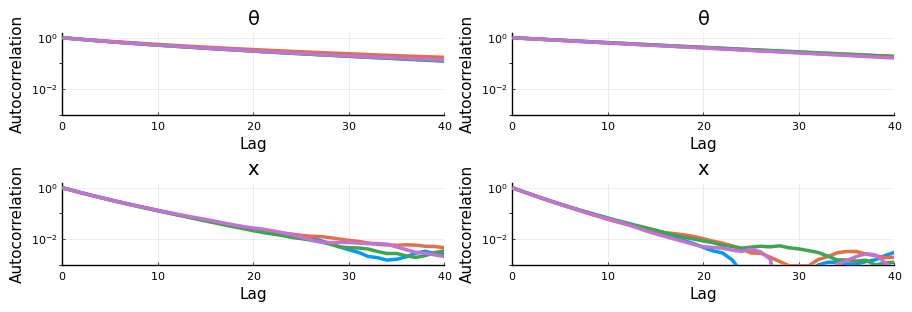

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/toy_model2_AM_autocor.pdf"

In [252]:
# Generate figure
Plots.pyplot()

# Create the autocorrelation plots
p1 = autocorplot(
    chn_original, 
    xlim=[0, 40],
    ylim=[10^(-3), 1.5], 
    yscale=:log10, 
    lw=2.5
)

p2 = autocorplot(
    chn_priorNormalized,
    xlim=[0, 40],
    ylim=[10^(-3), 1.5], 
    yscale=:log10, 
    lw=2.5
)

p3 = autocorplot( 
    chn_pullback,
    xlim=[0, 40],
    ylim=[10^(-3), 1.5], 
    yscale=:log10, 
    lw=2.5
)

# Combine the plots into a 1x2 layout
p_comb = StatsPlots.plot(
    p1, p3,  
    layout=(1, 2), 
    size=(900,300)
)

# Display the plot 
display(p_comb)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/toy_model$(model_nr)_AM_autocor.pdf")
#savefig(output_filename)

## Multivariate potential scale reduction factor (MPSRF)

In [253]:
# MPSRF for the original posterior

# Compute results
MPSRF = gelmandiag_multivariate(chn_original);
wall_duration = wall_duration_original
MPSRF_values = MPSRF[2] .- 1;
MPSRF_timesSec = MPSRF_values * wall_duration;

# Show results in scientific notation
@printf "wall_duration = %.1e\n" wall_duration
@printf "MPSRF = %.1e\n" MPSRF_values
@printf "MPSRFtimesSec = %.1e\n" MPSRF_timesSec

wall_duration = 2.6e+00
MPSRF = 2.9e-05
MPSRFtimesSec = 7.6e-05


In [254]:
# MPSRF for the prior-normalized posterior 

# Compute results
MPSRF = gelmandiag_multivariate(chn_pullback);
wall_duration = wall_duration_priorNormalized
MPSRF_values = MPSRF[2] .- 1;
MPSRF_timesSec = MPSRF_values * wall_duration;

# Show results in scientific notation
@printf "wall_duration = %.1e\n" wall_duration
@printf "MPSRF = %.1e\n" MPSRF_values
@printf "MPSRFtimesSec = %.1e\n" MPSRF_timesSec

wall_duration = 3.6e+00
MPSRF = 1.7e-05
MPSRFtimesSec = 6.1e-05


In [255]:
# Compute the MPSRF versus number of samples 
num_points = 5  # Number of equidistant points
nr_aux = length(chn_original[:, 1, 1])
increments = Int.( ceil.( maprange(log, 10^2, nr_aux, length=num_points) ))

# Array to store MPSRF values
MPSRF_values_original = Float64[]
MPSRF_values_priorNormalized = Float64[]

# Compute MPSRF for each subset of the chain
@showprogress for n in increments
    # Compute MPSRF for target chain 
    MPSRF = gelmandiag_multivariate(chn_original[1:n, :, :])
    push!(MPSRF_values_original, MPSRF[2])
    
    # Compute MPSRF for reference chain 
    MPSRF = gelmandiag_multivariate(chn_pullback[1:n, :, :] )
    push!(MPSRF_values_priorNormalized, MPSRF[2])
end

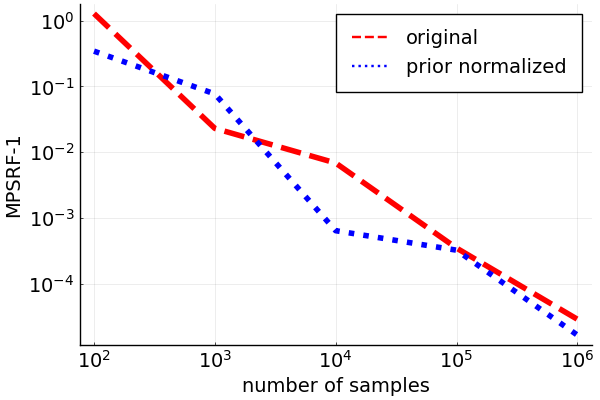

In [256]:
# Generate figure
pyplot()

# Set tick locations and labels
xticks = [10^1, 10^2, 10^3, 10^4, 10^5]
yticks = [10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2)]

# Create the plot 
plot_MPSRF = plot( increments, MPSRF_values_original.-1; 
    label="original", lw=4, ls=:dash, color = :red )
plot!( increments, MPSRF_values_priorNormalized.-1; 
    label="prior normalized", lw=4, ls=:dot, color = :blue )

# Make some cosmetic changes to the plot 
plot!( plot_MPSRF, 
    xscale=:log10, yscale=:log10, # log scale for x-axis and labels
    xlabel="number of samples", ylabel="MPSRF-1", # labels 
    tickfontsize=14, labelfontsize=14, legendfontsize=14#, # font sizes 
    #xticks=xticks, yticks=yticks
)

## Efective sample size (ESS)

In [257]:
I_all = size(chn_original, 1)
I_half = Int(ceil(I_all/2))
chn_original_half = chn_original[I_half:end, :, :];
chn_priorNormalized_half = chn_pullback[I_half:end, :, :];

In [258]:
# Compute the ESS for the θ- and x-samples
ESS_aux = ess(chn_original)
ESS_values = ESS_aux[:,2]
ess_θ = ESS_values[1]
ess_x = ESS_values[2]
wall_duration = wall_duration_original

# Compute the ESS per second 
ess_θ_perSec = ess_θ/wall_duration
ess_x_perSec = ess_x/wall_duration
ess_perSec = 0.5( ess_θ_perSec + ess_x_perSec )

# Show results in scientific notation
@printf "wall_duration = %.1e\n" wall_duration
@printf "ESS per sec. for θ = %.1e\n" ess_θ_perSec
@printf "ESS per sec. for x = %.1e\n" ess_x_perSec
@printf "Mean ESS per sec. = %.1e\n" ess_perSec

wall_duration = 2.6e+00
ESS per sec. for θ = 6.9e+04
ESS per sec. for x = 1.6e+05
Mean ESS per sec. = 1.1e+05


In [259]:
# Compute the ESS for the τ- and u-samples
ESS_aux = ess(chn_pullback)
ESS_values = ESS_aux[:,2]
ess_θ = ESS_values[1]
ess_x = ESS_values[2]
wall_duration = wall_duration_priorNormalized

# Compute the ESS per second 
ess_θ_perSec = ess_θ/wall_duration
ess_x_perSec = ess_x/wall_duration
ess_perSec = 0.5( ess_θ_perSec + ess_x_perSec )

# Show results in scientific notation
@printf "wall_duration = %.1e\n" wall_duration
@printf "ESS per sec. for θ = %.1e\n" ess_θ_perSec
@printf "ESS per sec. for x = %.1e\n" ess_x_perSec
@printf "Mean ESS per sec. = %.1e\n" ess_perSec

wall_duration = 3.6e+00
ESS per sec. for θ = 2.9e+04
ESS per sec. for x = 1.6e+05
Mean ESS per sec. = 9.3e+04
